In [103]:
import pandas as pd
import matplotlib.pyplot as plt

In [120]:
# Load data
pit = pd.read_csv('dataset/pit_stops.csv')
results = pd.read_csv('dataset/results.csv')
status = pd.read_csv('dataset/status.csv')
race = pd.read_csv('dataset/races.csv')
circuit = pd.read_csv('dataset/circuits.csv')
driver = pd.read_csv('dataset/drivers.csv')

In [121]:
# Merge tables
select_col = ['raceId','year','round','circuitId','name','date']
merge_df = pd.merge(pit, race[select_col], on='raceId', how='left')
select_col = ['raceId','driverId','positionOrder', 'laps', 'time','statusId']
merge_df = pd.merge(merge_df,results[select_col], on=['raceId','driverId'], how = 'left', suffixes=('_pit', '_result'))
merge_df = pd.merge(merge_df, status, on='statusId', how='left')
merge_df = pd.merge(merge_df, driver[['driverId', 'driverRef']], on = 'driverId', how='left')

Meaning of merge_df column: Status

+1 lap means that you have been overtaken by the race leader and that they are behind the race by 1 lap. So if the race has 30 laps , they are timed for 29 laps only hence +1.

If the winner is able to do it twice , it will be shown as +2 so on ...

In [122]:
# Filter records by their Status values
status_select = [1, 11, 12, 13, 14, 15, 16, 17, 18, 19]
merge_df.drop(merge_df[~merge_df['statusId'].isin(status_select)].index, inplace=True)

In [107]:
# Get the maximum number of laps in each race
race_lap = merge_df[(merge_df['positionOrder'] == 1) & (merge_df['stop'] == 1)].reset_index(drop=True)[['raceId', 'year', 'laps']]
race_lap

,raceId,year,laps
0,841,2011,58
1,842,2011,56
2,843,2011,56
3,844,2011,58
4,845,2011,66
...,...,...,...
192,1044,2020,58
193,1045,2020,57
194,1046,2020,87
195,1047,2020,55


In [108]:
# divide the pit stop times per race by driver (rank 1 in each race to find max laps)
pit_stop = merge_df.groupby(by=['raceId', 'driverId'], as_index=False)[['stop', 'lap']].max()
pit_stop

,raceId,driverId,stop,lap
0,841,1,2,36
1,841,2,2,30
2,841,4,3,42
3,841,10,1,18
4,841,13,3,48
...,...,...,...,...
3402,1052,844,2,32
3403,1052,846,2,33
3404,1052,847,2,36
3405,1052,852,2,33


In [109]:
def count_proportion(df_pit: pd.DataFrame, df_race: pd.DataFrame, decimal: int) -> pd.DataFrame:
    """
    add column with the proportion during the total laps in each race
    :param decimal:
    :param df_pit: pit dataframe
    :param df_race: race dataframe
    :return:
    >>> df = pd.DataFrame({"raceId":[1,2,3], "lap":[25, 15, 29]})
    >>> race = pd.DataFrame({"raceId":[1,2,3], "laps":[50, 60, 58]})
    >>> count_proportion(df,race, 2)
       raceId  lap  laps  proportion
    0       1   25    50        0.50
    1       2   15    60        0.25
    2       3   29    58        0.50
    """
    df_new = df_pit.merge(df_race[['raceId', 'laps']], on='raceId', how='left', suffixes=('_once', '_total'))
    df_new['proportion'] = round(df_new['lap'] / df_new['laps'], decimal)
    return df_new

In [110]:
# 1 pit stop
pit_once = pit_stop[pit_stop['stop']==1]

pit_once_temp = count_proportion(pit_once, race_lap, 1)
pit_once_temp

,raceId,driverId,stop,lap,laps,proportion
0,841,10,1,18,58,0.3
1,843,39,1,23,56,0.4
2,846,20,1,16,78,0.2
3,846,24,1,32,78,0.4
4,846,155,1,34,78,0.4
...,...,...,...,...,...,...
1019,1047,844,1,22,55,0.4
1020,1047,846,1,10,55,0.2
1021,1047,847,1,10,55,0.2
1022,1047,848,1,10,55,0.2


In [111]:
# 2 pit stop
pit_twice = pit_stop[pit_stop['stop']==2]
# back to merge_df df to get the first pit stop data
pit_twice= pd.merge(pit_twice[['raceId', 'driverId']],merge_df[['raceId', 'driverId', 'stop', 'lap']], on=['raceId', 'driverId'], how = 'left')
# then we have all data with pit stop twice
pit_twice_temp = count_proportion(pit_twice, race_lap, 2)
pit_twice_temp

,raceId,driverId,stop,lap,laps,proportion
0,841,1,1,16,58,0.28
1,841,1,2,36,58,0.62
2,841,2,1,15,58,0.26
3,841,2,2,30,58,0.52
4,841,15,1,16,58,0.28
...,...,...,...,...,...,...
2776,1052,847,2,36,56,0.64
2777,1052,852,1,15,56,0.27
2778,1052,852,2,33,56,0.59
2779,1052,854,1,14,56,0.25


In [112]:
# 3 pit stops and each stop or proportion
pit_third = pit_stop[pit_stop['stop']==3]
pit_third= pd.merge(pit_third[['raceId', 'driverId']],merge_df[['raceId', 'driverId', 'stop', 'lap']], on=['raceId', 'driverId'], how = 'left')
pit_third_temp = count_proportion(pit_third, race_lap, 2)
pit_third_temp

,raceId,driverId,stop,lap,laps,proportion
0,841,4,1,12,58,0.21
1,841,4,2,27,58,0.47
2,841,4,3,42,58,0.72
3,841,13,1,13,58,0.22
4,841,13,2,31,58,0.53
...,...,...,...,...,...,...
2172,1052,815,2,19,56,0.34
2173,1052,815,3,38,56,0.68
2174,1052,822,1,16,56,0.29
2175,1052,822,2,30,56,0.54


In [113]:
# 4 pit stops and each stop or proportion
pit_four = pit_stop[pit_stop['stop']==4]
pit_four= pd.merge(pit_four[['raceId', 'driverId']],merge_df[['raceId', 'driverId', 'stop', 'lap']], on=['raceId', 'driverId'], how = 'left')
pit_four_temp = count_proportion(pit_four, race_lap, 2)
pit_four_temp

,raceId,driverId,stop,lap,laps,proportion
0,842,1,1,12,56,0.21
1,842,1,2,24,56,0.43
2,842,1,3,37,56,0.66
3,842,1,4,52,56,0.93
4,842,4,1,14,56,0.25
...,...,...,...,...,...,...
751,1045,830,4,46,57,0.81
752,1046,847,1,45,87,0.52
753,1046,847,2,62,87,0.71
754,1046,847,3,63,87,0.72


<AxesSubplot:>

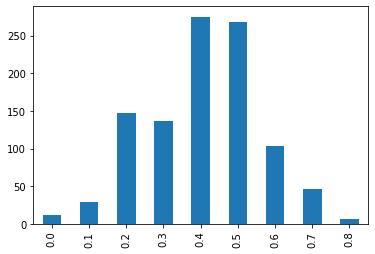

In [114]:
pit_once_temp.proportion.value_counts().sort_index().plot.bar()

In [115]:
pit_twice_temp[pit_twice_temp['stop'] == 1].proportion

0       0.28
2       0.26
4       0.28
6       0.28
8       0.24
        ... 
2771    0.21
2773    0.21
2775    0.23
2777    0.27
2779    0.25
Name: proportion, Length: 1390, dtype: float64

In [116]:
pit_one_mean = pit_once_temp.proportion.mean()
pit_one_std = pit_once_temp.proportion.std()

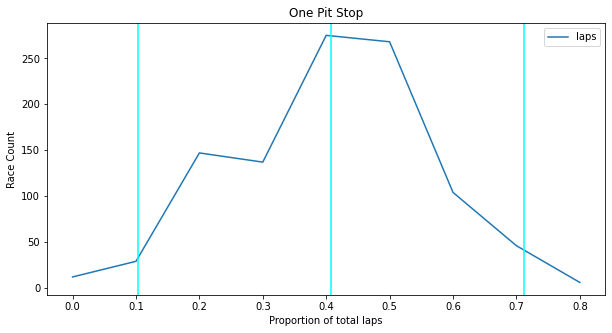

In [117]:
# plot for pit stop once
pit_once_plot = pit_once_temp.groupby(by=['proportion']).count().reset_index()
plot_line_chart(pit_once_plot, 1, 'One Pit Stop')
plt.axvline(x=pit_one_mean, color='cyan')
plt.axvline(x=pit_one_mean+2*pit_one_std, color='cyan')
plt.axvline(x=pit_one_mean-2*pit_one_std, color='cyan')

In [118]:
len(pit_once_temp.proportion[(pit_once_temp.proportion <= pit_one_mean + pit_one_std) & (pit_once_temp.proportion >= pit_one_mean - pit_one_std)])/len(pit_once_temp.proportion)

0.6640625

In [119]:
len(pit_once_temp.proportion[(pit_once_temp.proportion <= pit_one_mean + 2*pit_one_std) & (pit_once_temp.proportion >= pit_one_mean - 2*pit_one_std)])/len(pit_once_temp.proportion)

0.9541015625